# 1: Walking Distance Heatmaps

###### Notebook to generate maps that visually color nodes based on their distances from the center (+ 1km outer bounds) of the given location, map of road intersections as nodes and map indicating a city center.

###### In this case the maps are exported as png. This can be adjusted to other file formats.

### Setting up packages and variables

In [1]:
import os
import pandas
import rtree
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import networkx as nx
import osmnx as ox
import pandas as pa
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__
import pygeos
gpd.options.use_pygeos = True


miev_pink = '#f06675'
miev_blue = '#2c3174'
miev_yellow = '#fbe56d'

/root/venv/lib/python3.9/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


### Configuration type of network, speed and trip times

In [2]:
# configure the place, network type, trip times, and travel speed
place = 'Binnenstad, Delft, Netherlands'

# walking 
network_type = 'all'
trip_times = [5, 10, 15, 20, 25] #in minutes
travel_speed = 5.0 #walking speed in km/hour

# cycling [uncomment to calculate for cycling roads and speed]
# network_type = 'bike'
# trip_times = [5, 10, 15] #in minutes
# travel_speed = 16.9 #cycling speed in km/hour

### Download network and plot

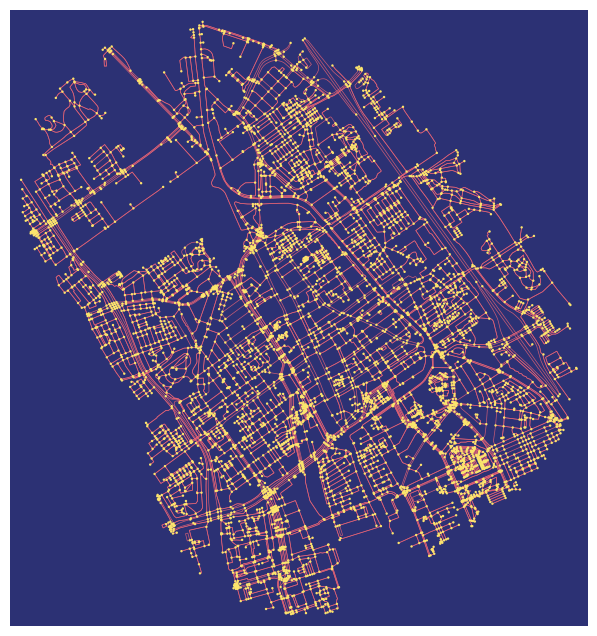

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [3]:
# download the street network with inner city + 1km buffer
G = ox.graph_from_place(place, network_type, buffer_dist=1000)

# download street network for inner city
G_nonbuffer = ox.graph_from_place(place, network_type)

# plot network
ox.plot_graph(G, filepath='data/intersections.png', save=True, node_size=3, node_color= miev_yellow, node_zorder=2, 
                bgcolor= miev_blue, edge_color= miev_pink, edge_linewidth=0.5, 
                edge_alpha=0.8)

In [4]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

### Start location configuration

In [5]:
# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G_nonbuffer, edges=False)

# get x and y coordinates of centermost node of the geometry
x = gdf_nodes['geometry'].unary_union.centroid.x
y = gdf_nodes['geometry'].unary_union.centroid.y

# define center node by inputting coordinates (x=lat, y=lng)
center_node = ox.nearest_nodes(G, x, y)

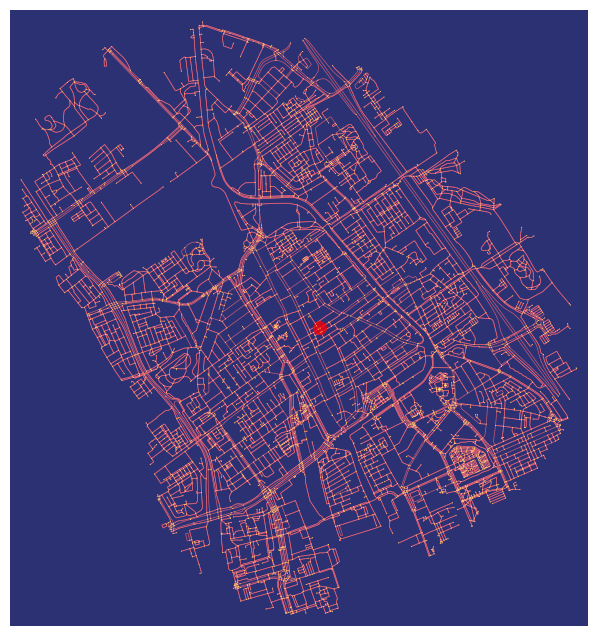

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [6]:
# plot center node
ox.plot_graph_route(G, [center_node], filepath='data/center_node.png', save=True, node_color= miev_yellow, node_zorder=2, 
                    node_size=0.5, bgcolor= miev_blue, edge_color= miev_pink, 
                    edge_linewidth=0.5, edge_alpha=0.8)  

### Projecting graph

In [7]:
# project graph for later thingy (its late)
G = ox.project_graph(G)

### Coloring nodes according to their distance 

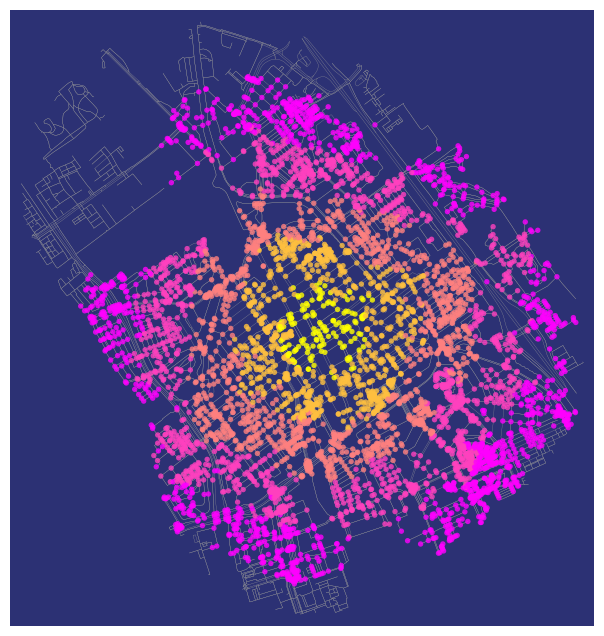

In [8]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='spring', start=0, 
                                return_hex=True)

# color the nodes according to isochrone distance to center then plot the network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, filepath='data/nodes_heatmap.png', save=True, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2,
                        bgcolor=miev_blue, edge_linewidth=0.2, edge_color='#999999')

/root/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


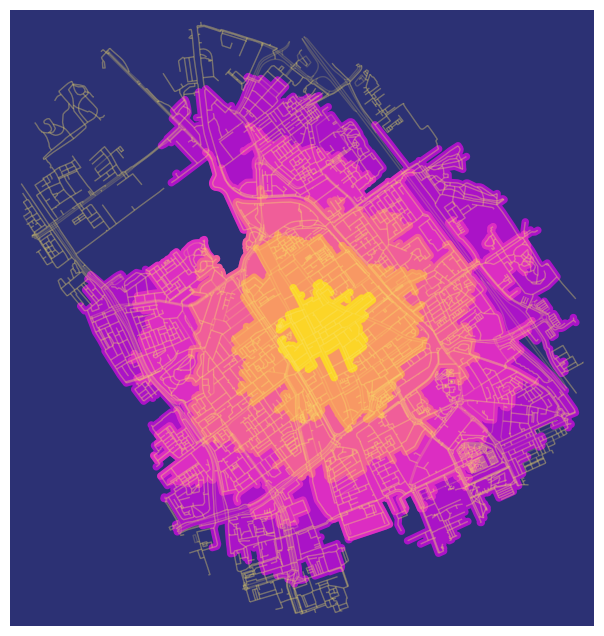

In [9]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear solid and 
        # blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
fig, ax = ox.plot_graph(G, filepath='data/heatmap.png', save=True, show=False, close=False, edge_color=miev_yellow, edge_alpha=0.2,
                        node_size=0, bgcolor=miev_blue)
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8966f7b1-6d03-4f20-86ea-afcd52732bbc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>